# NSY benchmark

In [23]:
import sys,os
import numpy as np
import sympy as sp
import pylab as py
from qgraf.qgraf import QGRAF
from form.form import FORM
from tools.tools import load
from scipy.integrate import quad
from sympy.parsing.sympy_parser import parse_expr
lprint=lambda expression: display(Math(sp.latex(expression)))
%matplotlib inline
sp.init_printing()

In [3]:
def to_sympy(exp):
    ATOMS=[]
    exp=exp.replace('^','**')
    atoms=exp.replace('*',' ').replace('+',' ').replace('-',' ')
    atoms=atoms.replace('/',' ').replace('(',' ').replace(')',' ').split()
    atoms=sorted(set(atoms))
    for a in atoms:
        try: 
            int(a)
        except:
            ATOMS.append(a)
    ATOMS=sorted(set(ATOMS))
    for a in ATOMS:
        exec '%s=sp.Symbol("%s")'%(a,a)
    return parse_expr(exp)

## Create sympy symbols to be use across the notebook

In [55]:
CF=4/sp.S(3)
#gs2=sp.Symbol('gs2')
#gu2=sp.Symbol('gu2')
#gd2=sp.Symbol('gd2')
Q=sp.Symbol('Q')
s=sp.Symbol('s')
s12=sp.Symbol('s_12')
t1=sp.Symbol('t_1')
u1=sp.Symbol('u_1')
t2=sp.Symbol('t_2')
u2=sp.Symbol('u_2')
qT=sp.Symbol('q_T')
xh=sp.Symbol('\hat{x}')
zh=sp.Symbol('\hat{z}')
x=sp.Symbol('x')
z=sp.Symbol('z')
y=sp.Symbol('y')

## generate amps and sqamps with qgraf

- A, B, C and D now correspond to the figures in the paper


In [56]:
process={}
process['bornA']={'in':'A[p1],u[p2]','out':'u[q1],G[q2]'}
process['bornB']={'in':'A[p1],u[p2]','out':'G[q1],u[q2]'}
process['bornC']={'in':'A[p1],G[p2]','out':'u[q1],ub[q2]'}
process['bornD']={'in':'A[p1],G[p2]','out':'ub[q1],u[q2]'}

In [57]:
for k in process:
    conf={}                          
    conf['path2qgraf']='./qgraf/'          
    conf['label']=k           
    conf['style']='array.sty'        
    conf['model']='SM'               
    conf['in']=process[k]['in']        
    conf['out']=process[k]['out']       
    conf['loops']=0;                 
    conf['loop_momentum']=''     
    conf['extra']=[]
    conf['options']='notadpole'      
    process[k]['qgraf']=QGRAF(conf).data

In [112]:
for k in process: 
    if k!='bornC': continue
    for sqamp in process[k]['qgraf']['SQAMPS']: 
        print k,sqamp,':'
        print '\t',process[k]['qgraf']['SQAMPS'][sqamp]

bornC [a0*ca0] :
	(+1)*eps(A,p1,s1,MA,o1)*eps(G,p2,s2,MG,o2,j2)*(+1)*epsB(A,p1,s1,MA,o1001)*epsB(G,p2,s2,MG,o1002,j1002)*U(sc1,u,q1,r1,Mu)*UB(sc1,u,q1,r1,Mu)*(-i_)*gu^1*gI_(sc1,o1)*i_*(g_(sc1,-p1)+g_(sc1,+q1)+g_(sc1)*Mu)*den(-p1+q1,Mu)*(-i_)*gs^1*gI_(sc1,o2)*V(sc1,ub,q2,r2,Mu)*VB(sc1,ub,q2,r2,Mu)*(i_)*gs^1*gI_(sc1,o1002)*(-i_)*(g_(sc1,-p1)+g_(sc1,+q1)+g_(sc1)*Mu)*den(-p1+q1,Mu)*(i_)*gu^1*gI_(sc1,o1001)*Tr(j2,j1002)
bornC [a0*ca1] :
	(+1)*eps(A,p1,s1,MA,o1)*eps(G,p2,s2,MG,o2,j2)*(+1)*epsB(A,p1,s1,MA,o1001)*epsB(G,p2,s2,MG,o1002,j1002)*U(sc1,u,q1,r1,Mu)*UB(sc1,u,q1,r1,Mu)*(-i_)*gu^1*gI_(sc1,o1)*i_*(g_(sc1,-p1)+g_(sc1,+q1)+g_(sc1)*Mu)*den(-p1+q1,Mu)*(-i_)*gs^1*gI_(sc1,o2)*V(sc1,ub,q2,r2,Mu)*VB(sc1,ub,q2,r2,Mu)*(i_)*gu^1*gI_(sc1,o1001)*(-i_)*(g_(sc1,p1)+g_(sc1,-q2)+g_(sc1)*Mu)*den(p1-q2,Mu)*(i_)*gs^1*gI_(sc1,o1002)*Tr(j2,j1002)
bornC [a1*ca1] :
	(+1)*eps(A,p1,s1,MA,o1)*eps(G,p2,s2,MG,o2,j2)*(+1)*epsB(A,p1,s1,MA,o1001)*epsB(G,p2,s2,MG,o1002,j1002)*U(sc1,u,q1,r1,Mu)*UB(sc1,u,q1,r1,Mu)*(-i_)*

## use form to compute traces and convert expression into sympy expression

In [135]:
for k in process:
    process[k]['Pg']=None
    process[k]['Ppp']=None
    for kk in ['Pg','Ppp']:
        conf={}
        conf['label']=k
        conf['path2form']='./form'
        conf['qgraf']=process[k]['qgraf']
        conf['projection']='%s.frm'%kk
        terms=FORM(conf).data['total']
        combine=0
        for term in terms:
            term=to_sympy(term)
            term=term.subs('gs**2',1)
            term=term.subs('gu**2',1)
            term=term.subs('gd**2',1)
            term=term.subs('D',4)
            term=term.subs(s12,s)
            term=term.subs("t1",t1)
            term=term.subs("u1",u1)
            term=term.subs("u2",t1)
            term=term.subs("t2",u1)
            term=term.subs("Q2",Q**2)
            combine+=term
        process[k][kk]=sp.simplify(combine)

## Display squared amplituds

In [168]:
for k in ['bornA','bornB','bornC','bornD']:
    for kk in ['Pg','Ppp']:
        print k,kk,':'
        print '\t',process[k][kk]

bornA Pg :
	32*ave*(Q**2*s**2*(Q**2 + s + u_1) + Q**2*t_1**2*(Q**2 + t_1 + u_1) + s**2*t_1*(Q**2 + s + 2*u_1) + s*t_1**2*(Q**2 + t_1 + 2*u_1) + 2*s*t_1*u_1**2)/(s**2*t_1**2)
bornA Ppp :
	-16*ave*u_1*(Q**4 + 2*Q**2*s + 2*Q**2*u_1 + s**2 + 2*s*u_1 + u_1**2)/t_1**2
bornB Pg :
	32*ave*(Q**2*s**2*(Q**2 + s + t_1) + Q**2*u_1**2*(Q**2 + t_1 + u_1) + s**2*u_1*(Q**2 + s + 2*t_1) + 2*s*t_1**2*u_1 + s*u_1**2*(Q**2 + 2*t_1 + u_1))/(s**2*u_1**2)
bornB Ppp :
	-16*ave*t_1*(Q**4 + 2*Q**2*s + 2*Q**2*t_1 + s**2 + 2*s*t_1 + t_1**2)/u_1**2
bornC Pg :
	-32*ave*(Q**2*t_1**2*(Q**2 + s12 + t_1) + Q**2*u_1**2*(Q**2 + s12 + u_1) + 2*s12**2*t_1*u_1 + t_1**2*u_1*(Q**2 + 2*s12 + t_1) + t_1*u_1**2*(Q**2 + 2*s12 + u_1))/(t_1**2*u_1**2)
bornC Ppp :
	16*ave*(t_1**3*(Q**4 + Q**2*s + Q**2*s12 + 2*Q**2*t_1 + s*s12 + s*t_1 + s12*t_1 + t_1**2) - 2*t_1**2*u_1**2*(Q**2 + s12 + t_1 + u_1) + t_1**2*u_1*(-Q**2*s12 + Q**2*t_1 - s*s12 + t_1**2) + t_1*u_1**2*(-Q**2*s12 + Q**2*u_1 - s*s12 + u_1**2) + u_1**3*(Q**4 + Q**2*s + Q**2*s1

In [148]:
sqamps={}
for k in ['bornA','bornB','bornC','bornD']:
    sqamps[k]={}
    for kk in ['Pg','Ppp']:
        sqamps[k][kk]=process[k][kk].subs("D",sp.S(4))
        #sqamps[k][kk]=sqamps[k][kk]*CF/(sp.S(4)/sp.S(3))
        if k=='bornA' or k=='bornB': sqamps[k][kk]=process[k][kk].subs("ave",1/sp.S(2*3))        
        if k=='bornC' or k=='bornD': sqamps[k][kk]=process[k][kk].subs("ave",1/sp.S(2*8))

In [149]:
M2g=sqamps['bornA']['Pg'].simplify()
M2pp=sqamps['bornA']['Ppp'].simplify()

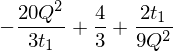

In [150]:
f1GWRS=(-M2g+12*xh**2/Q**2*M2pp)/sp.S(4)
f1GWRS=f1GWRS.subs(u1,-Q**2-s-t1)
f1GWRS=f1GWRS.subs(xh,Q**2/(s+Q**2))
f1GWRS=f1GWRS.subs(s,2*Q**2)
f1GWRS.simplify()

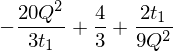

In [151]:
f1NSY=2*CF*xh*zh*(1/qT**2*(Q**4/xh**2/zh**2+(Q**2-qT**2)**2)+6*Q**2) / (2*Q**2)
f1NSY=f1NSY.subs(qT**2,(-t1-Q**2*(1-zh))/zh)
f1NSY=f1NSY.subs(zh,-u1*xh/Q**2)
f1NSY=f1NSY.subs(u1,-Q**2-s-t1)
f1NSY=f1NSY.subs(xh,Q**2/(s+Q**2))
f1NSY=f1NSY.subs(s,2*Q**2)
f1NSY.simplify()

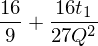

In [152]:
f2GWRS=2*xh**2/Q**2*M2pp
f2GWRS=f2GWRS.subs(u1,-Q**2-s-t1)
f2GWRS=f2GWRS.subs(xh,Q**2/(s+Q**2))
f2GWRS=f2GWRS.subs(s,2*Q**2)
f2GWRS.simplify()

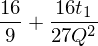

In [153]:
f2NSY=2*CF*xh*zh*4*Q**2/(2*Q**2)
f2NSY=f2NSY.subs(qT**2,(-t1-Q**2*(1-zh))/zh)
f2NSY=f2NSY.subs(zh,-u1*xh/Q**2)
f2NSY=f2NSY.subs(u1,-Q**2-s-t1)
f2NSY=f2NSY.subs(xh,Q**2/(s+Q**2))
f2NSY=f2NSY.subs(s,2*Q**2)
f2NSY.simplify()

In [154]:
M2g=sqamps['bornB']['Pg'].simplify()
M2pp=sqamps['bornB']['Ppp'].simplify()

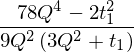

In [155]:
f1GWRS=(-M2g+12*xh**2/Q**2*M2pp)/sp.S(4)
f1GWRS=f1GWRS.subs(u1,-Q**2-s-t1)
f1GWRS=f1GWRS.subs(xh,Q**2/(s+Q**2))
f1GWRS=f1GWRS.subs(s,2*Q**2)
f1GWRS.simplify()

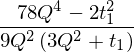

In [156]:
qTt=zh*qT/(1-zh)
f1NSY=2*CF*xh*(1-zh)*(1/qTt**2*(Q**4/xh**2/(1-zh)**2+(Q**2-qTt**2)**2)+6*Q**2) / (2*Q**2)
f1NSY=f1NSY.subs(qT**2,(-t1-Q**2*(1-zh))/zh)
f1NSY=f1NSY.subs(zh,-u1*xh/Q**2)
f1NSY=f1NSY.subs(u1,-Q**2-s-t1)
f1NSY=f1NSY.subs(xh,Q**2/(s+Q**2))
f1NSY=f1NSY.subs(s,2*Q**2)
f1NSY.simplify()

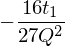

In [157]:
f2GWRS=2*xh**2/Q**2*M2pp
f2GWRS=f2GWRS.subs(u1,-Q**2-s-t1)
f2GWRS=f2GWRS.subs(xh,Q**2/(s+Q**2))
f2GWRS=f2GWRS.subs(s,2*Q**2)
f2GWRS.simplify()

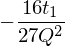

In [158]:
f2NSY=2*CF*xh*(1-zh)*4*Q**2/(2*Q**2)
f2NSY=f2NSY.subs(qT**2,(-t1-Q**2*(1-zh))/zh)
f2NSY=f2NSY.subs(zh,-u1*xh/Q**2)
f2NSY=f2NSY.subs(u1,-Q**2-s-t1)
f2NSY=f2NSY.subs(xh,Q**2/(s+Q**2))
f2NSY=f2NSY.subs(s,2*Q**2)
f2NSY.simplify()

In [159]:
M2g=sqamps['bornC']['Pg'].simplify()
M2pp=sqamps['bornC']['Ppp'].simplify()

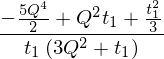

In [164]:
f1GWRS=(-M2g+12*xh**2/Q**2*M2pp)/sp.S(4)
f1GWRS=f1GWRS.subs(u1,-Q**2-s-t1)
f1GWRS=f1GWRS.subs(xh,Q**2/(s+Q**2))
f1GWRS=f1GWRS.subs("s12",s)
f1GWRS=f1GWRS.subs(s,2*Q**2)
#f1GWRS=f1GWRS.subs(t1,-Q**2/2)

f1GWRS.simplify()

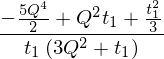

In [165]:
f1NSY=xh*(1-xh)*(Q**4/qT**2*(1/xh**2/zh**2-2/xh/zh+2)+2*Q**2*(5-1/xh-1/zh)) / (2*Q**2)
f1NSY=f1NSY.subs(qT**2,(-t1-Q**2*(1-zh))/zh)
f1NSY=f1NSY.subs(zh,-u1*xh/Q**2)
f1NSY=f1NSY.subs(u1,-Q**2-s-t1)
f1NSY=f1NSY.subs(xh,Q**2/(s+Q**2))
f1NSY=f1NSY.subs(s,2*Q**2)
#f1NSY=f1NSY.subs(t1,-Q**2/2)
f1NSY.simplify()

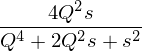

In [166]:
f2GWRS=2*xh**2/Q**2*M2pp
f2GWRS=f2GWRS.subs(u1,-Q**2-s-t1)
f2GWRS=f2GWRS.subs(xh,Q**2/(s+Q**2))
#f2GWRS=f2GWRS.subs(s,2*Q**2)
f2GWRS.simplify()

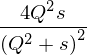

In [167]:
f2NSY=xh*(1-xh)*4*Q**2*2/(2*Q**2)
f2NSY=f2NSY.subs(qT**2,(-t1-Q**2*(1-zh))/zh)
f2NSY=f2NSY.subs(zh,-u1*xh/Q**2)
f2NSY=f2NSY.subs(u1,-Q**2-s-t1)
f2NSY=f2NSY.subs(xh,Q**2/(s+Q**2))
#f2NSY=f2NSY.subs(s,2*Q**2)
f2NSY.simplify()